In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('seaborn')

In [2]:
users = pd.read_csv('rating.csv')
anime = pd.read_csv('anime.csv')

In [3]:
print (len(anime))
print (anime.rating)
anime.head()

12294
0        9.37
1        9.26
2        9.25
3        9.17
4        9.16
5        9.15
6        9.13
7        9.11
8        9.10
9        9.11
10       9.06
11       9.05
12       9.04
13       8.98
14       8.93
15       8.93
16       8.92
17       8.88
18       8.84
19       8.83
20       8.83
21       8.83
22       8.82
23       8.82
24       8.81
25       8.81
26       8.80
27       8.80
28       8.78
29       8.78
         ... 
12264    6.42
12265     NaN
12266    5.43
12267    4.11
12268    2.86
12269    4.08
12270    3.00
12271    5.20
12272    4.14
12273    4.00
12274     NaN
12275    3.14
12276    4.00
12277    4.66
12278    3.61
12279     NaN
12280     NaN
12281    4.53
12282     NaN
12283    4.95
12284    4.45
12285     NaN
12286    4.67
12287    4.33
12288    4.37
12289    4.15
12290    4.28
12291    4.88
12292    4.98
12293    5.46
Name: rating, dtype: float64


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
print (len(users))
users.head()


7813737


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


So we have two pandas data frames. In the first, we have information regarding a particular anime. The information here speaks for itself. In the second data frame, we have the actual ratings for a given user/ anime pair. Ratings range from 1 to 10, with -1 signifying a completed but unrated movie.

We can see there are 12294 total anime and 7.8 million user/ rating pairs. The first thing we want to do is remove all ratings that are "-1" as they don't provide us useful information on ratings. There are also some anime with NaNs for scores. We'll want to remove those, but let's wait a second on that.

In [5]:
users.drop(users[users.rating == -1].index, inplace=True)

print (len(users))
users.head()

6337241


,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10


Neat. We trimmed down about 1.5 million data points. But that's still too many. Let's, for the purposes of this analysis, focus only on TV shows. We're going to need a list of anime_ids corresponding to non-TV shows. Let's kill two birds with one stone and include anime that have null ratings for whatever reason.

In [6]:
bad_ids = anime.anime_id[(anime.type != 'TV') | (anime.rating.isnull())]
users.drop(users[users.anime_id.map(lambda x: x in bad_ids)].index, inplace=True)
anime.drop(anime[(anime.type != 'TV') | (anime.rating.isnull())].index, inplace=True)

print(len(users))
print(len(anime))

3594754
3671


Neat. We cut down to 3.6 million user/anime pairs, with 3671 unique TV titles. Note that we cut down about 75% of anime entries, yet the number of user/anime pairs cut down by less than 50%. Those titles (movies, specials, OVAs) obviously had less interest, so our resulting data is denser. That's good for our recommender systems. 

We'll want to wrap this code in a pre-processing function in a package down the line, but for this exploratory analysis, I'll leave it as such.

Let's visualize the data. Let's do some basic stuff first.

min: 2.670000; max: 9.600000
mean: 6.902299; median: 6.940000


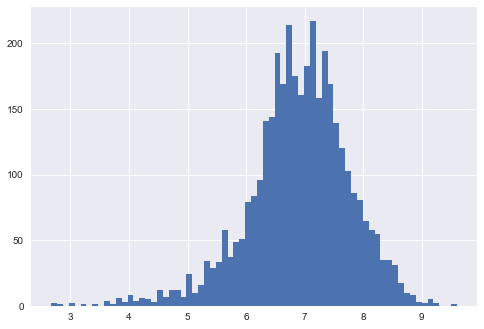

In [7]:
print ("min: %f; max: %f" % (anime.rating.min(), anime.rating.max()))
print ("mean: %f; median: %f" % (anime.rating.mean(axis=0), anime.rating.median(axis=0)))
nBins = int((anime.rating.max()-anime.rating.min())/0.1) #nBins such that each bin corresponds to a 0.1 range
anime.rating.hist(bins=nBins) 



The data is skewed left, but not significantly so. The mean and median are very close to each other, at about 6.9. We also see spikes at the bins corresponding to [6.7, 6.8) and [7.1, 7.2), for whatever reason.

Can we run the same analysis but on a genre-by-genre basis? First, we need to get a list of genres. This probably isn't the most efficient way to do it. 

In [8]:
genres = anime.genre.apply(lambda x: str(x).split(","))
genres2 = genres.apply(pd.Series)
all_genres = []
for i in range(len(genres2.columns)):
    genres2[i] = genres2[i].str.strip()
    all_genres += map(lambda s: str(s).strip(), list(genres2[i].unique()))
all_genres = list(np.unique(all_genres))
all_genres.remove('nan')

In [28]:
import plotly.plotly as py
import plotly.graph_objs as go

data = [];

for genre in all_genres:
    ratings = anime.rating[(genres2[0:] == genre).any(axis=1)]
    data.append( go.Histogram(
        x=ratings,
        histnorm='probability density',
        opacity=0.40,
        name=genre,
    ))
    
    
layout = go.Layout(barmode='overlay')
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='anime comparison')


Man, plotly is awesome. (If you don't see a chart here, you're probably reading this on Github. Try opening it in nbviewer: https://nbviewer.jupyter.org/)

So this chart is a bit hard to understand at first, so it'll be more useful to instead toggle off most of these histograms. Double click on a genre of choice (say, action) in the legend to see only the plot for action. And then single click any other genres (e.g. romance) to see them overlaid. Note that with two categories, we have 3 colors, corresponding to each show as well as the places where they're combined. 

If we do that, we can see that that romance looks fairly similarly distributed to action, but shifted right a little bit. So it seems either the anime community likes romances a little bit more, or anime romances in general are a little bit better (or both!).

We can actually compare distributions, parameterized by mean & standard deviation (those do look sort of Gaussian, after all), and more easily interpret the data. 

In [9]:
stats = []
for genre in all_genres:
    ratings = anime.rating[(genres2[0:] == genre).any(axis=1)]
    stats.append([ratings.mean(), ratings.std()])

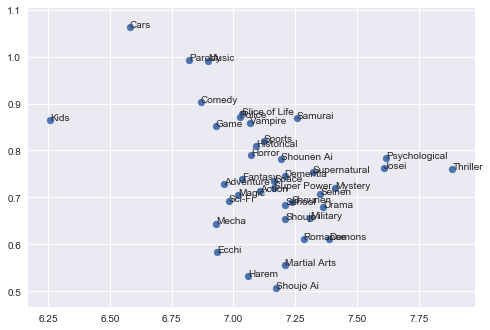

In [10]:
fig, ax = plt.subplots()

x = np.array(stats)[:,0]
y = np.array(stats)[:,1]

plt.scatter(x, y)

for i, txt in enumerate(all_genres):
    ax.annotate(txt, (x[i],y[i]))


Something further to the right means a higher mean value (more acclaimed), and further upwards means a higher std value (more disagreement). So we find thriller and psychological shows are among the more acclaimed, whereas kids shows are not looked at highly. We also find music, parody, and comedy shows to have high levels of disagreement -- which makes sense, as these are subjective in nature.

It should be pretty clear that in a recommender system, we'll want to incorporate genre information as a feature (duh!).

Now, let's examine users. First, let's look at the distributions of how many anime they've watched.

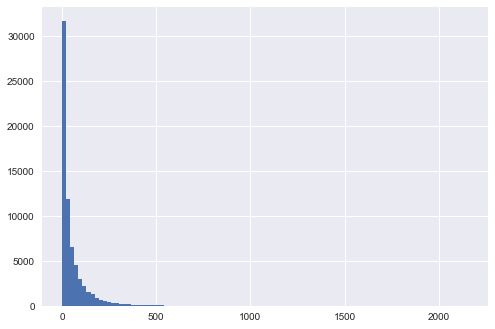

In [11]:
users.user_id.value_counts().hist(bins=100)

So it looks like an exponential curve, but the plot is too scaled out. Let's drop out users who have seen more than 250 anime for the sake of visualization. 

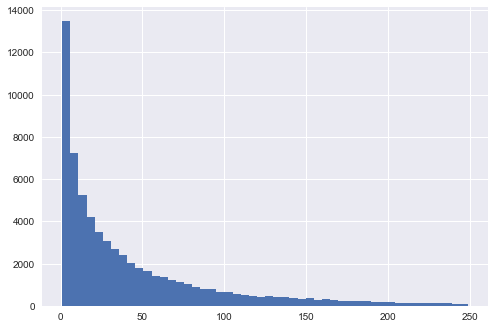

In [12]:
vc = users.user_id.value_counts()
vc = vc[vc.map(lambda x: x < 250)]
vc.hist(bins=50)

The exponential decay of how many anime the a user has seen is pretty clear from this chart. As noted before, recommender systems work best with relatively dense data, i.e. when users have rated several products. We might find it useful, then, to remove users that have seen fewer than a certain amount of anime. This will be a hyper-parameter when we fit recommender systems. Let's go ahead and remove users who have seen fewer than 10 anime, for now.

In [13]:
vc = users.user_id.value_counts()
low_ratings = vc[vc.map(lambda x: x < 10)].index
users.drop(users[users.user_id.map(lambda x: x in low_ratings)].index, inplace=True)
print(len(users))
users.head()

3516162


,user_id,anime_id,rating
156,3,20,8
159,3,199,10
164,3,552,7
168,3,1122,7
170,3,1292,6


We lose only about 80,000 user/anime pairs, but now our dataset is more robust. The number 10 was chosen arbitrarily, of course. When we build a recommender system, we can change it based on validation error or on computational limitations. 

Finally, let's get a sense of how people (who've rated more than 10 TV shows) rate, by plotting two histograms, one of mean score and one of standard deviation.

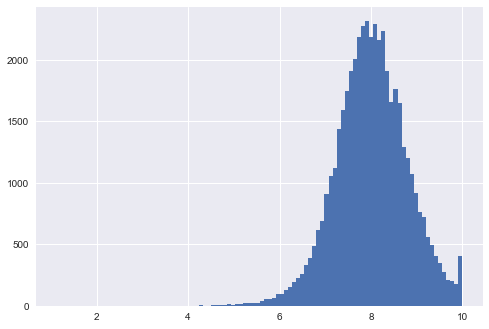

In [32]:
users.groupby('user_id')['rating'].agg(pd.np.mean).hist(bins=100)

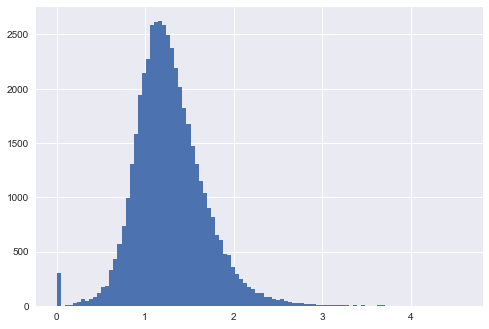

In [33]:
users.groupby('user_id')['rating'].agg(pd.np.std).hist(bins=100)

This might be my inner statistics geek showing, but I really love how Gaussian the means looks and how Chi-Square (albeit with a high degree of freedom) the standard deviations look. We also note there are some folks who just give a whole lot of 10s and nothing else, causing spikes in each of the graph.